**Overview**

Conjunto de datos transaccionales que contiene todas las transacciones que se produjeron entre el 12/01/2010 y el 12/09/2011 para una tienda minorista en línea y con sede en el Reino Unido. La empresa vende principalmente regalos únicos para toda ocasión. Muchos clientes de la empresa son mayoristas.

**Objetivo comercial**

El objetivo es segmentar a los Clientes en función de **RFM** para que la empresa pueda captar a sus clientes de manera eficiente.

Recency, frequency, monetary value (**RFM**) es una herramienta de análisis de marketing que se utiliza para identificar a los mejores clientes de una empresa en función de la naturaleza de sus hábitos de compras.

**Atributos:**

**InvoiceNo:** Número de factura. Nominal, un número entero de 6 dígitos asignado de forma única a cada transacción. Si este código comienza con la letra 'c', indica una cancelación.

**StockCode:** Código del producto (artículo). Nominal, un número entero de 5 dígitos asignado de forma única a cada producto distinto.

**Description:** Nombre del producto (artículo). Nominal.

**Quantity:** Las cantidades de cada producto (artículo) por transacción. Numérico.

**InvoiceDate:** Fecha y hora de la factura. Numérico, el día y la hora en que se generó cada transacción.

**UnitPrice:** Precio unitario. Numérico, precio del producto por unidad en libras esterlinas.

**CustomerID:** Número de cliente. Nominal, un número entero de 5 dígitos asignado de forma única a cada cliente.

**Country:** Nombre del país. Nominal, el nombre del país donde reside cada cliente.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

**Paso 1: Lectura y comprensión de datos**

In [38]:
retail = pd.read_csv('/content/drive/MyDrive/CTIC_UNI/DATA_SCIENCE/COURSE_01_MAY_2022/SESION06/data/OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [39]:
retail.shape

(541909, 8)

In [40]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [41]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


**Paso 2: Limpieza de datos**

In [42]:
df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [43]:
retail = retail.dropna()
retail.shape

(406829, 8)

In [44]:
retail['CustomerID'] = retail['CustomerID'].astype(str)

**Paso 3 : Preparando Data**

Vamos a analizar a los Clientes en función de los siguientes 3 factores:

R (Recency): Número de días desde la última compra

F (Frecuencia): Número de transacciones

M (Monetario): Importe total de las transacciones (ingresos aportados)

In [45]:
#Nuevo atributo para acumular el importe total

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [46]:
# Nuevo atributo : Frequencia

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [47]:
# Mezclando los dos dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [48]:
# Nuevo atributo : Recency

# Convertimos a datetime 

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [49]:
# Calculamos la maxima fecha para conocer las fecha de la ultima transaccion

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [50]:
# Calculamos la diferencia entre la fecha maxima y la fecha de la transaccion

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [51]:
# Calculamos la fecha de la ultima transaccion para obtener la recency de los clientes

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [52]:
# Extraemos el numero de dias

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [53]:
# Mezclamos los dataframes para obtener el RFM dataframe final

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Hay 2 tipos de valores atípicos y debemos tratarlos ya que pueden sesgar nuestro conjunto de datos.

Estadístico

Específico del dominio

Text(0.5, 0, 'Atributos')

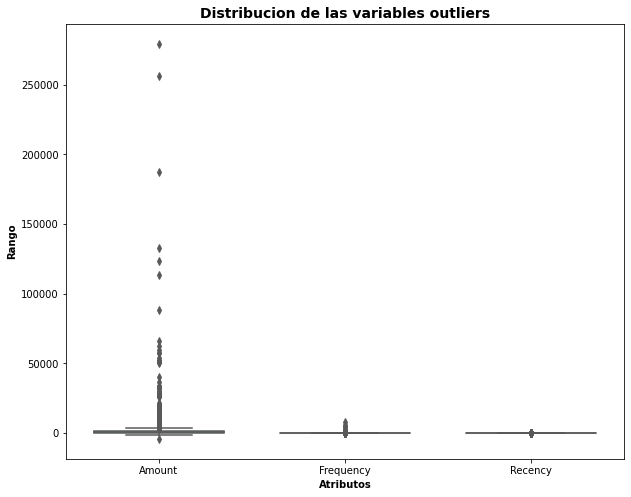

In [54]:
# Analisis de Outlier  de Amount Frequency y Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Distribucion de las variables outliers", fontsize = 14, fontweight = 'bold')
plt.ylabel("Rango", fontweight = 'bold')
plt.xlabel("Atributos", fontweight = 'bold')

In [55]:
# Removiendo outliers(estadisticos) para Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removiendo outliers(estadisticos) for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removiendo outliers(estadisticos) for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

Cambio de escala de los atributos:

Es sumamente importante reescalar las variables para que tengan una escala comparable. Hay dos formas comunes de cambiar la escala:

Escalado mínimo-máximo

Estandarización (media-0, sigma-1)

Aquí, utilizaremos la escala de estandarización.

In [56]:
# Reescalando los atributos

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instanciando
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [57]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


**Paso 4: Construcción del modelo**

**K-Means Clustering**

In [58]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)


KMeans(max_iter=50, n_clusters=4)

In [59]:
kmeans.labels_

array([1, 0, 2, ..., 1, 2, 2], dtype=int32)

Encontrando el número óptimo de clusters

Elbow Curve:

Elbow Curve para obtener el número correcto de clusters
Un paso fundamental para cualquier algoritmo no supervisado es determinar el número óptimo de clusters en los que se pueden agrupar los datos. El método Elbow es uno de los métodos más populares para determinar este valor óptimo de k.

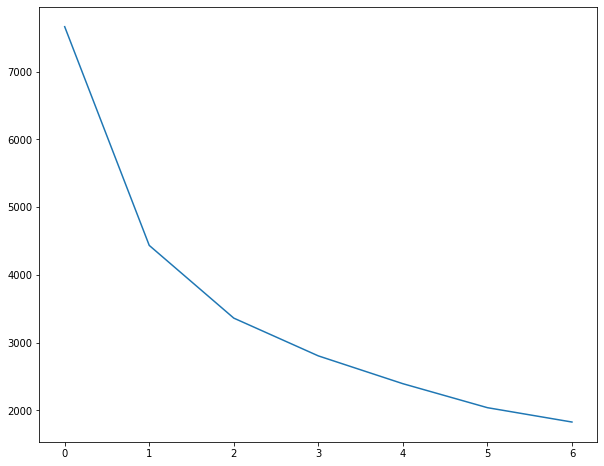

In [60]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# Graficamos el SSDs para cada n_clusters
plt.plot(ssd)

Silhouette Analysis:

silhouette score=𝑝−𝑞/𝑚𝑎𝑥(𝑝,𝑞)

𝑝 es la distancia media a los puntos en el grupo más cercano del que el punto de datos no forma parte

𝑞 es la distancia media dentro del grupo a todos los puntos en su propio grupo.

El valor del rango de puntuación de la silueta se encuentra entre -1 y 1.

Una puntuación más cercana a 1 indica que el punto de datos es muy similar a otros puntos de datos en el grupo,

Una puntuación más cercana a -1 indica que el punto de datos no es similar a los puntos de datos en su grupo.

In [61]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.4816217519322445
For n_clusters=5, the silhouette score is 0.46627005641897035
For n_clusters=6, the silhouette score is 0.41713672616001374
For n_clusters=7, the silhouette score is 0.41537918961846826
For n_clusters=8, the silhouette score is 0.3947444365255789


In [62]:
# Modelo final con k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [63]:
kmeans.labels_

array([0, 1, 2, ..., 0, 2, 2], dtype=int32)

In [64]:
# asignar la etiqueta
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,2
3,12349.0,1757.55,73,18,2
4,12350.0,334.40,17,309,0


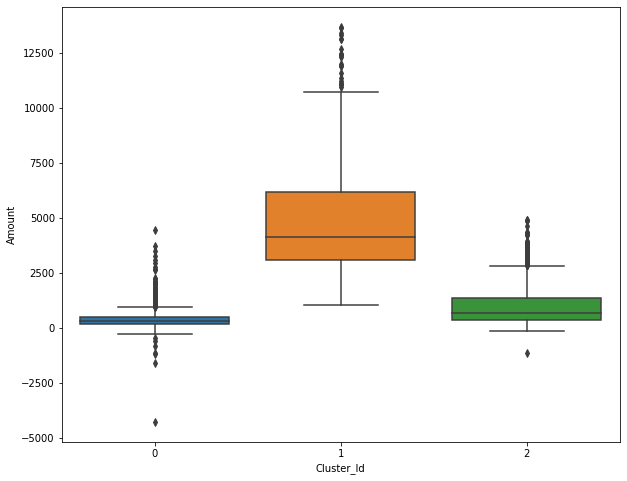

In [65]:
# Box plot para visualizar Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

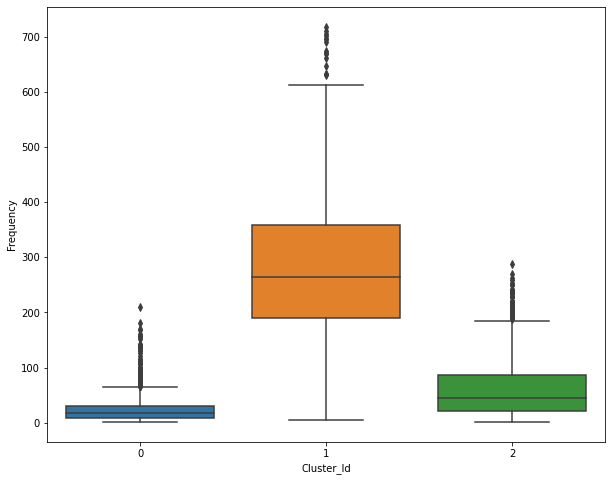

In [66]:
# Box plot para visualizar Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

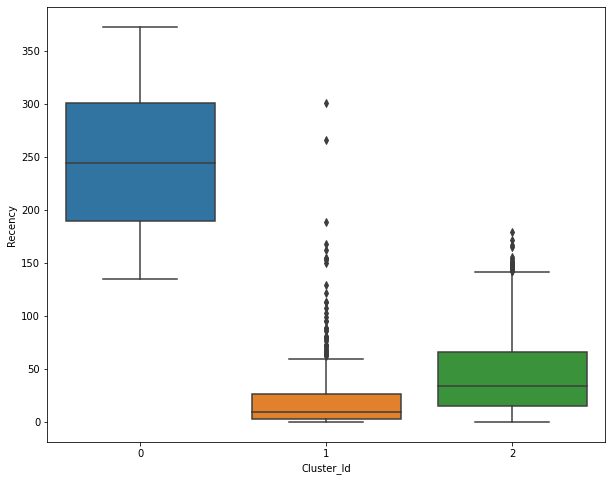

In [67]:
# Box plot para visualizar Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

**Hierarchical Clustering**

La agrupación jerárquica implica la creación de grupos que tienen un orden predeterminado de arriba a abajo. Por ejemplo, todos los archivos y carpetas del disco duro están organizados en una jerarquía. Hay dos tipos de agrupamiento jerárquico,

Divisivo

Aglomerativo

Enlace único:

En el agrupamiento jerárquico de enlace único, la distancia entre dos grupos se define como la distancia más corta entre dos puntos en cada grupo. Por ejemplo, la distancia entre los grupos "r" y "s" a la izquierda es igual a la longitud de la flecha entre sus dos puntos más cercanos.

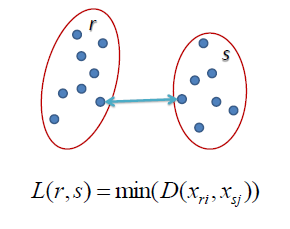

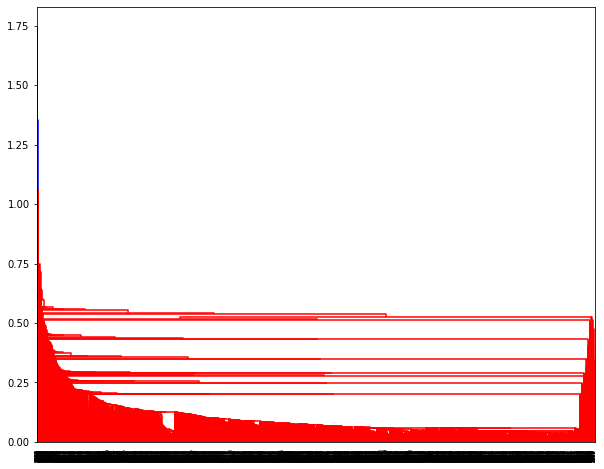

In [68]:
# Single linkage: 

mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

Vinculación completa

En el agrupamiento jerárquico de enlace completo, la distancia entre dos grupos se define como la distancia más larga entre dos puntos en cada grupo. Por ejemplo, la distancia entre los grupos "r" y "s" a la izquierda es igual a la longitud de la flecha entre sus dos puntos más alejados.

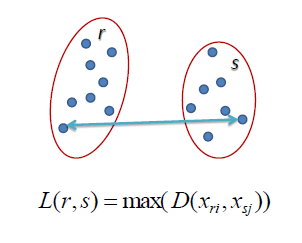

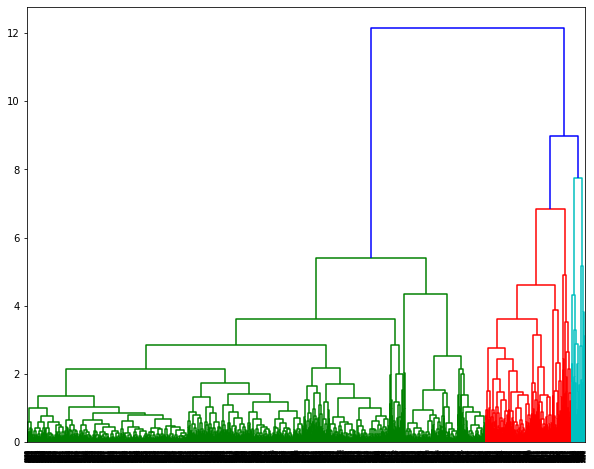

In [69]:
# Complete linkage

mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

Vinculación promedio:

En el agrupamiento jerárquico de vinculación promedio, la distancia entre dos conglomerados se define como la distancia promedio entre cada punto de un conglomerado y cada punto del otro conglomerado. Por ejemplo, la distancia entre los grupos "r" y "s" a la izquierda es igual a la longitud promedio de cada flecha entre los puntos que conectan un grupo con el otro.

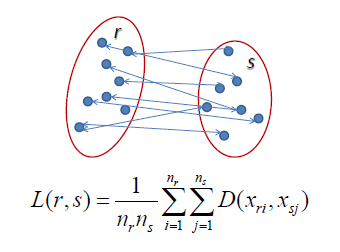

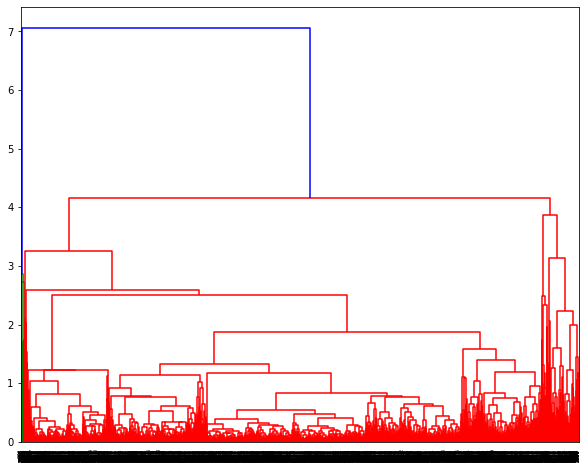

In [70]:
# Average linkage

mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

Cortando el Dendograma basado en K

In [71]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [72]:
# Asignamos cluster labels

rfm['Cluster_Labels'] = cluster_labels
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels
0,12346.0,0.00,2,325,0,0
1,12347.0,4310.00,182,1,1,0
2,12348.0,1797.24,31,74,2,0
3,12349.0,1757.55,73,18,2,0
4,12350.0,334.40,17,309,0,0


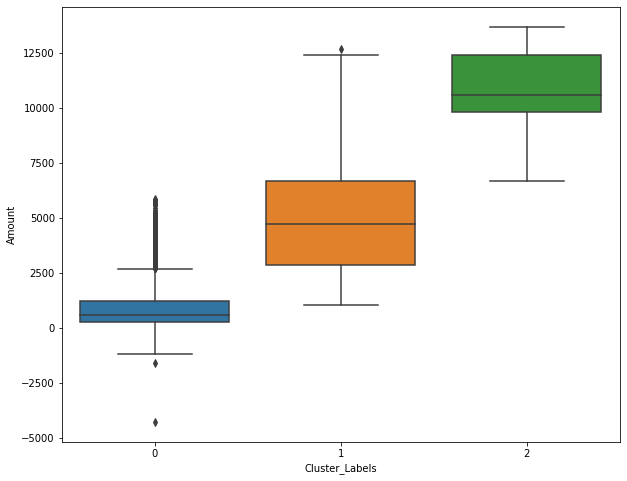

In [73]:
# Graficamos Cluster Id vs Amount

sns.boxplot(x='Cluster_Labels', y='Amount', data=rfm)

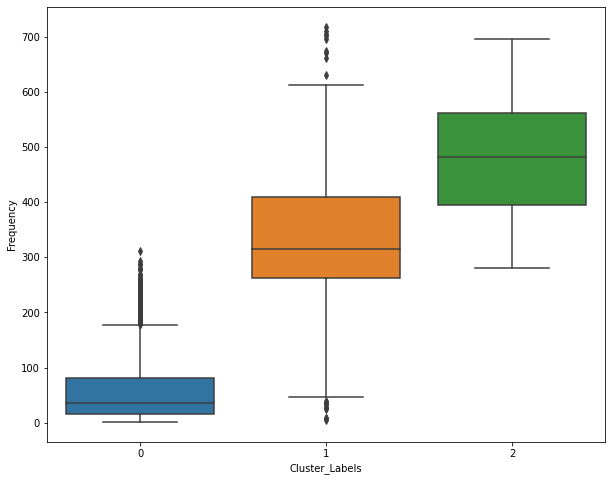

In [74]:
# Graficamos Cluster Id vs Frequency

sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

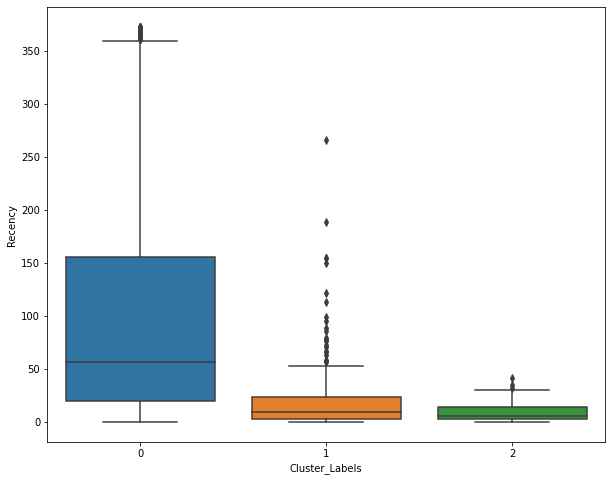

In [75]:
# Graficamos Cluster Id vs Recency

sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)

**Paso 5: Análisis final**

Inferencia:

**K-Means** con 3 clusters id

Los clientes con ID de clúster 1 son los clientes con una gran cantidad de transacciones en comparación con otros clientes.

Los clientes con ID de clúster 1 son compradores frecuentes.

Los clientes con ID de clúster 2 no son compradores recientes y, por lo tanto, tienen menos importancia desde el punto de vista empresarial.

**Hierarchical Cluster** con 3 etiquetas de clúster

Los clientes con Cluster_Labels 2 son los clientes con una gran cantidad de transacciones en comparación con otros clientes.

Los clientes con Cluster_Labels 2 son compradores frecuentes.

Los clientes con Cluster_Labels 0 no son compradores recientes y, por lo tanto, tienen menos importancia desde el punto de vista empresarial.